<a href="https://colab.research.google.com/github/sanscurtodavis/demo_portfolio/blob/main/notes_1_8_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import modules




In [39]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Download data and define variables required

In [75]:
# Set given parameters for testing environment
start_date = "2020-01-01"
end_date = "2025-01-01"
short_window = 5
long_window = 30
initial_balance = 10000

In [76]:
# Generate long and short signals for data
def generate_long_short_signals(data):
  position = 0
  for i in range(1, len(data)):
    # SMA Short passes over SMA long -> buy signal
    if data['SMA_Short'].iloc[i - 1] <= data['SMA_Long'].iloc[i - 1] and data['SMA_Short'].iloc[i] > data['SMA_Long'].iloc[i]:
      data.loc[data.index[i], 'Signal'] = 1
      position = 1
    # SMA Long passes over SMA short -> sell signal
    elif data['SMA_Short'].iloc[i - 1] >= data['SMA_Long'].iloc[i - 1] and data['SMA_Short'].iloc[i] < data['SMA_Long'].iloc[i]:
      data.loc[data.index[i], 'Signal'] = -1
      position = 0
    data.loc[data.index[i], 'Position'] = position

# Fetch historical data
def get_data(ticker, start_date, end_date):
  data = yf.download(ticker, start=start_date, end=end_date)
  data['SMA_Short'] = data['Close'][ticker].rolling(window=short_window).mean()
  data['SMA_Long'] = data['Close'][ticker].rolling(window=long_window).mean()
  data['Signal'] = 0
  data['Position'] = 0
  data['Daily_Return'] = data['Close'].pct_change()

  generate_long_short_signals(data)

  data['Strategy_Return'] = data['Position'].shift(1) * data['Daily_Return']
  data['Buy_and_Hold'] = initial_balance * (data['Close'] / data['Close'].iloc[0])
  data['Portfolio_Value'] = initial_balance * (1 + data['Strategy_Return']).cumprod()
  data.iloc[0, data.columns.get_loc('Portfolio_Value')] = initial_balance
  return data

# Plot price, SMAs, and portfolio performance
def plot_data(data, ticker):
  plt.figure(figsize=(10, 5))
  plt.plot(data['Close'], label="SPY Price")
  plt.plot(data['SMA_Short'], label=f"{short_window}-Day SMA")
  plt.plot(data['SMA_Long'], label=f"{long_window}-Day SMA")
  plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label="Long", marker="^", color="green")
  plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label="Short", marker="v", color="red")
  plt.title(f"{ticker} SMA Trading Strategy")
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(data['Portfolio_Value'], label="Portfolio Value")
  plt.plot(data['Buy_and_Hold'], label="Buy and Hold")
  plt.title(f"{ticker} Portfolio Performance")
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend()
  plt.show()

# Function to calculate metrics
def calculate_metrics(data):
  initial_balance = data['Portfolio_Value'].iloc[0]
  final_portfolio_value = data['Portfolio_Value'].iloc[-1]
  cumulative_pnl_dollars = final_portfolio_value - initial_balance
  cumulative_pnl_percent = (cumulative_pnl_dollars / initial_balance) * 100
  trading_years = len(data) / 252
  daily_pnl_dollars = cumulative_pnl_dollars / trading_years
  daily_pnl_percent = (daily_pnl_dollars / initial_balance) * 100
  roi = (final_portfolio_value / initial_balance - 1) * 100

  # Portfolio returns (daily)
  returns = data['Portfolio_Value'].pct_change().dropna()
  sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252))

  # Sortino Ratio
  downside_returns = returns[returns < 0]
  sortino_ratio = (returns.mean() * 252) / (downside_returns.std() * np.sqrt(252))

  # Return results
  results = {
      'Final Portfolio Value': final_portfolio_value,
      'Cumulative PnL ($)': cumulative_pnl_dollars,
      'Cumulative PnL (%)': cumulative_pnl_percent,
      'Daily PnL ($)': daily_pnl_dollars,
      'Daily PnL (%)': daily_pnl_percent,
      'ROI (%)': roi,
      'Sharpe Ratio': sharpe_ratio,
      'Sortino Ratio': sortino_ratio
  }
  results_df = pd.DataFrame(list(results.items()), columns=['Metric', 'Value'])
  return results_df

# Function to calculate Buy and Hold metrics
def calculate_buy_hold_results(data):
  initial_balance = data['Buy_and_Hold'].iloc[0]
  final_portfolio_value = data['Buy_and_Hold'].iloc[-1]
  cumulative_pnl_dollars = final_portfolio_value - initial_balance
  cumulative_pnl_percent = (cumulative_pnl_dollars / initial_balance) * 100
  trading_years = len(data) / 252
  daily_pnl_dollars = cumulative_pnl_dollars / trading_years
  daily_pnl_percent = (daily_pnl_dollars / initial_balance) * 100
  roi = (final_portfolio_value / initial_balance - 1) * 100

  # Portfolio returns (daily)
  returns = data['Buy_and_Hold'].pct_change().dropna()
  sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252))

  # Sortino Ratio
  downside_returns = returns[returns < 0]
  sortino_ratio = (returns.mean() * 252) / (downside_returns.std() * np.sqrt(252))

  # Return results
  results = {
      'Final Portfolio Value': final_portfolio_value,
      'Cumulative PnL ($)': cumulative_pnl_dollars,
      'Cumulative PnL (%)': cumulative_pnl_percent,
      'Daily PnL ($)': daily_pnl_dollars,
      'Daily PnL (%)': daily_pnl_percent,
      'ROI (%)': roi,
      'Sharpe Ratio': sharpe_ratio,
      'Sortino Ratio': sortino_ratio
  }
  results_df = pd.DataFrame(list(results.items()), columns=['Metric', 'Value'])
  return results_df

In [77]:
spy_data = get_data("SPY", start_date, end_date)
spy_data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,SMA_Short,SMA_Long,Signal,Position,Daily_Return,Strategy_Return,Buy_and_Hold,Portfolio_Value
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,
Date,,,,,,,,,,,,,
2020-01-02,301.194885,301.213446,299.025418,299.961822,59151200,NaN,NaN,0,0,NaN,NaN,10000.000000,10000.000000
2020-01-03,298.914215,300.054588,297.699684,297.755309,77709700,NaN,NaN,0,0,-0.007572,-0.0,9924.279253,10000.000000
2020-01-06,300.054535,300.137973,297.013540,297.134071,55653900,NaN,NaN,0,0,0.003815,0.0,9962.139120,10000.000000
2020-01-07,299.210907,299.961876,298.756597,299.479753,40496400,NaN,NaN,0,0,-0.002812,-0.0,9934.129749,10000.000000
2020-01-08,300.805542,302.038605,299.155262,299.405575,68296000,300.036017,NaN,0,0,0.005329,0.0,9987.073377,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,601.299988,601.340027,595.469971,596.059998,33160100,591.117480,596.679936,0,0,0.011115,0.0,19963.818021,15953.548219
2024-12-26,601.340027,602.479980,598.080017,599.500000,41219100,594.522803,596.894676,0,0,0.000067,0.0,19965.147361,15953.548219


In [78]:
qqq_data = get_data("QQQ", start_date, end_date)
qqq_data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,SMA_Short,SMA_Long,Signal,Position,Daily_Return,Strategy_Return,Buy_and_Hold,Portfolio_Value
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,
Date,,,,,,,,,,,,,
2020-01-02,209.638062,209.638062,207.523828,207.931154,30969400,NaN,NaN,0,0,NaN,NaN,10000.000000,10000.000000
2020-01-03,207.717773,208.968860,206.844934,206.864335,27518900,NaN,NaN,0,0,-0.009160,-0.000000,9908.399836,10000.000000
2020-01-06,209.056137,209.085231,205.836316,206.088466,21655300,NaN,NaN,0,0,0.006443,0.000000,9972.241470,10000.000000
2020-01-07,209.027100,209.618695,208.367623,209.133781,22139300,NaN,NaN,0,0,-0.000139,-0.000000,9970.856346,10000.000000
2020-01-08,210.598190,211.558326,208.668242,208.997980,26397300,209.207452,NaN,0,0,0.007516,0.000000,10045.799354,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,529.960022,530.049988,524.190002,524.830017,17558200,519.927136,515.509316,0,1,0.013560,0.013560,25279.761610,19233.440052
2024-12-26,529.599976,531.239990,526.309998,528.320007,19090500,522.719434,516.093174,0,1,-0.000679,-0.000679,25262.586943,19220.373159


In [79]:
# Set portfolio value to initial balance
portfolio_value = initial_balance

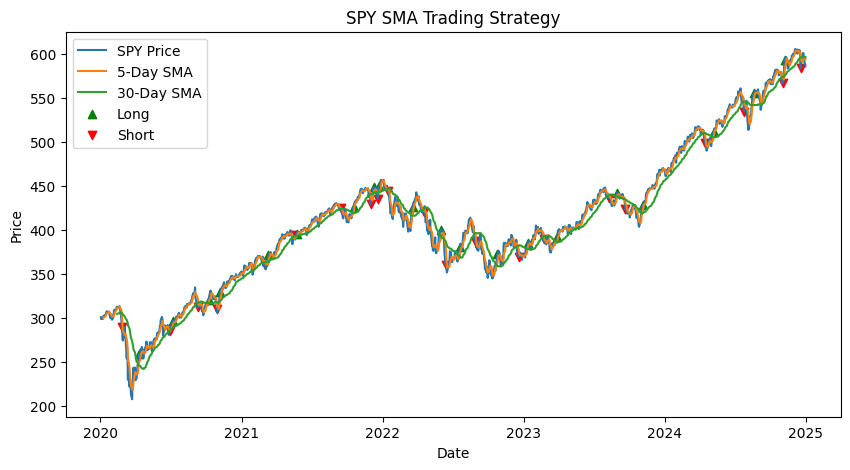

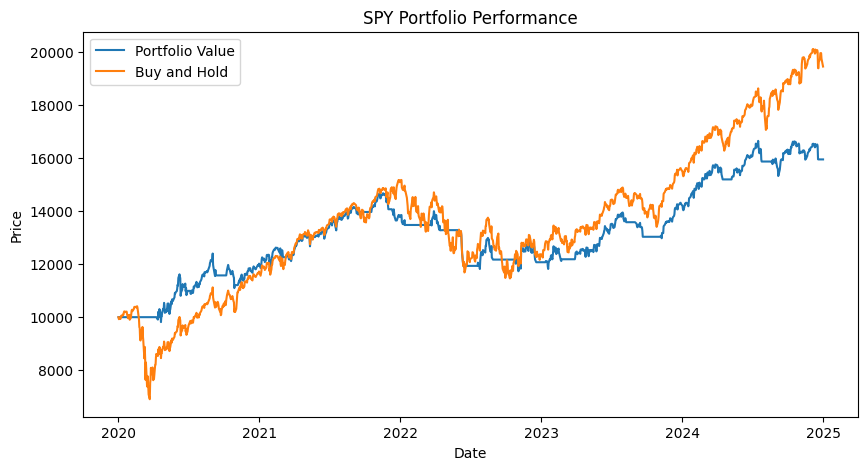

In [80]:
plot_data(spy_data, "SPY")

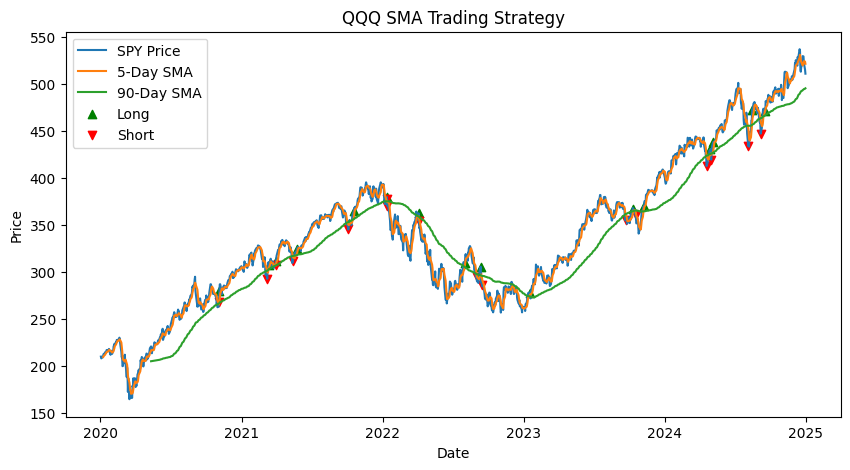

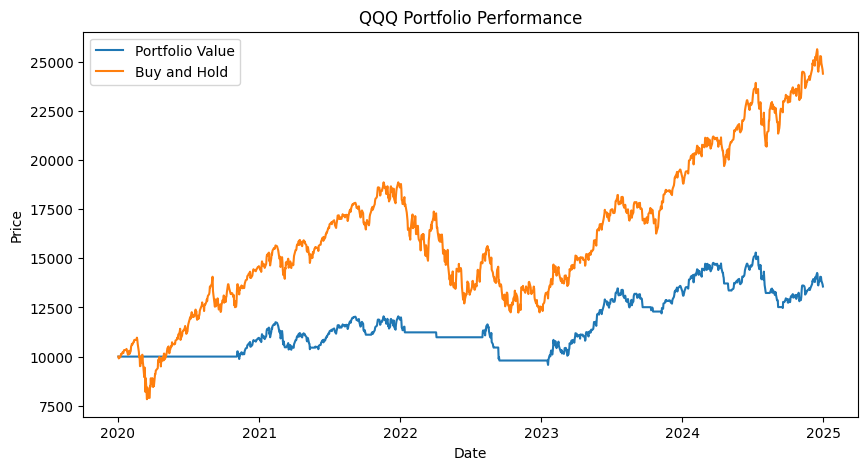

In [71]:
plot_data(qqq_data, "QQQ")

In [81]:
# Collect metrics for both strategies
spy_sma_metrics = calculate_metrics(spy_data)
spy_bh_metrics = calculate_buy_hold_results(spy_data)

qqq_sma_metrics = calculate_metrics(qqq_data)
qqq_bh_metrics = calculate_buy_hold_results(qqq_data)

# Create a DataFrame for comparison
metrics_matrix = pd.DataFrame({
    'SPY_SMA': [
        spy_sma_metrics.loc[spy_sma_metrics['Metric'] == 'ROI (%)', 'Value'].values[0],
        spy_sma_metrics.loc[spy_sma_metrics['Metric'] == 'Sharpe Ratio', 'Value'].values[0],
        spy_sma_metrics.loc[spy_sma_metrics['Metric'] == 'Sortino Ratio', 'Value'].values[0]
    ],
    'SPY_Buy_Hold': [
        spy_bh_metrics.loc[spy_bh_metrics['Metric'] == 'ROI (%)', 'Value'].values[0],
        spy_bh_metrics.loc[spy_bh_metrics['Metric'] == 'Sharpe Ratio', 'Value'].values[0],
        spy_bh_metrics.loc[spy_bh_metrics['Metric'] == 'Sortino Ratio', 'Value'].values[0]
    ],
    'QQQ_SMA': [
        qqq_sma_metrics.loc[qqq_sma_metrics['Metric'] == 'ROI (%)', 'Value'].values[0],
        qqq_sma_metrics.loc[qqq_sma_metrics['Metric'] == 'Sharpe Ratio', 'Value'].values[0],
        qqq_sma_metrics.loc[qqq_sma_metrics['Metric'] == 'Sortino Ratio', 'Value'].values[0]
    ],
    'QQQ_Buy_Hold': [
        qqq_bh_metrics.loc[qqq_bh_metrics['Metric'] == 'ROI (%)', 'Value'].values[0],
        qqq_bh_metrics.loc[qqq_bh_metrics['Metric'] == 'Sharpe Ratio', 'Value'].values[0],
        qqq_bh_metrics.loc[qqq_bh_metrics['Metric'] == 'Sortino Ratio', 'Value'].values[0]
    ]
}, index=['ROI (%)', 'Sharpe Ratio', 'Sortino Ratio'])

# Display the matrix
metrics_matrix


,SPY_SMA,SPY_Buy_Hold,QQQ_SMA,QQQ_Buy_Hold
ROI (%),59.535482,94.584983,85.536859,143.863165
Sharpe Ratio,0.817143,0.741232,0.871134,0.825712
Sortino Ratio,0.867260,0.907104,0.961034,1.086000


In [82]:
spy_sma_metrics

,Metric,Value
0,Final Portfolio Value,15953.548219
1,Cumulative PnL ($),5953.548219
2,Cumulative PnL (%),59.535482
3,Daily PnL ($),1192.602664
4,Daily PnL (%),11.926027
5,ROI (%),59.535482
6,Sharpe Ratio,0.817143
7,Sortino Ratio,0.867260


In [83]:
qqq_sma_metrics

,Metric,Value
0,Final Portfolio Value,18553.685865
1,Cumulative PnL ($),8553.685865
2,Cumulative PnL (%),85.536859
3,Daily PnL ($),1713.456946
4,Daily PnL (%),17.134569
5,ROI (%),85.536859
6,Sharpe Ratio,0.871134
7,Sortino Ratio,0.961034
